In [1]:
import pandas as pd
from os import getenv
from db import Postgres 
from utils.rpc import RPC
from utils import read_file_json
from datetime import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from decimal import Decimal

load_dotenv()

True

In [2]:
RPC_URL = 'http://10.7.0.58:8545'
DSN_POSTGRES = getenv('DSN_POSTGRES')

In [3]:
rpc = RPC(RPC_URL)
db = Postgres(DSN_POSTGRES)

In [4]:
# Database bundles time range query
oldest_timestamp = datetime.fromtimestamp(db.query('SELECT MIN(timestamp) FROM bundles')[0][0])
latest_timestamp = datetime.fromtimestamp(db.query('SELECT MAX(timestamp) FROM bundles')[0][0])
print(f'Time range from {oldest_timestamp} to {latest_timestamp}')

Time range from 2022-09-15 13:43:47 to 2024-09-26 09:20:11


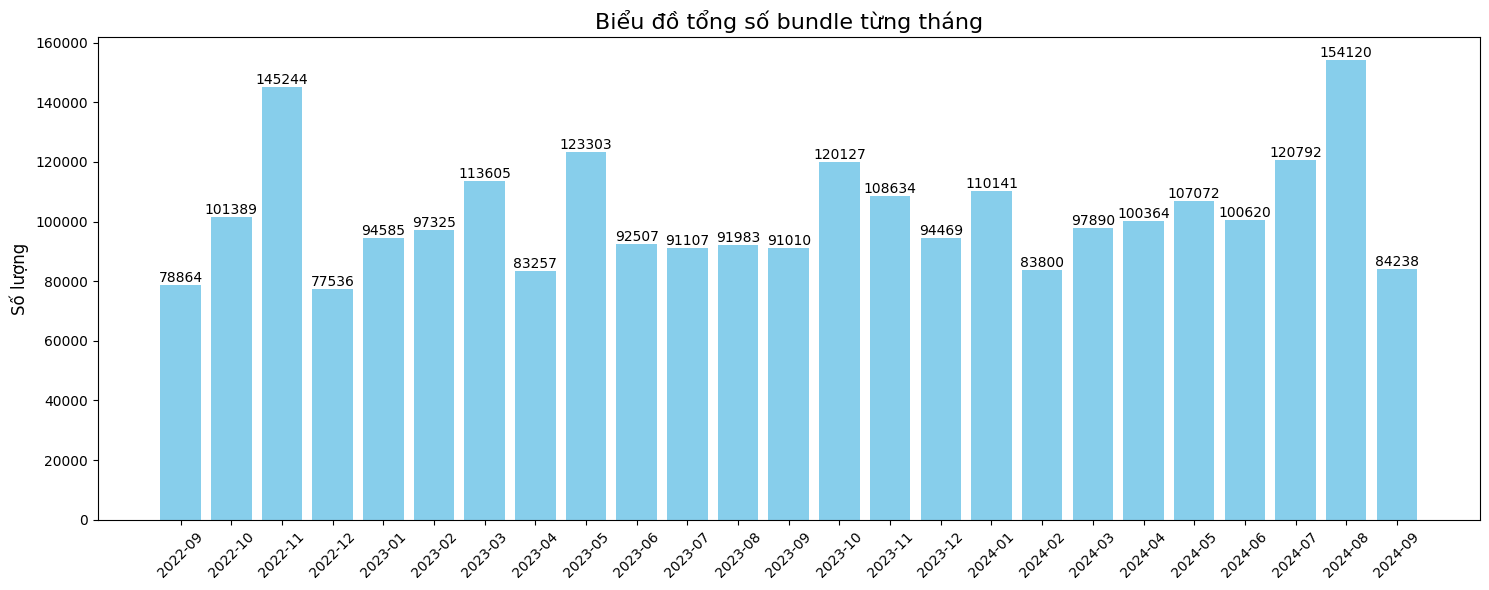

In [5]:
# Plot count bundle by month

bundles_by_month = db.query(f"""
    SELECT 
        date_trunc('month', to_timestamp(timestamp)) AS month,
        COUNT(1) AS bundle_count
    FROM bundles
    GROUP BY month
""")

df = pd.DataFrame(bundles_by_month, columns=['month', 'bundle_count'])
df['month'] = pd.to_datetime(df['month']).dt.strftime('%Y-%m')

plt.figure(figsize=(15, 6))
plt.bar(df['month'], df['bundle_count'], color='skyblue')
bars = plt.bar(df['month'], df['bundle_count'], color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, yval, 
             ha='center', va='bottom', fontsize=10)
    
plt.title('Biểu đồ tổng số bundle từng tháng', fontsize=16)
plt.ylabel('Số lượng', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Plot profit eth by month

profit_eth_by_month = db.query(f"""
    SELECT 
        date_trunc('month', to_timestamp(timestamp)) AS month,
        SUM(profit_eth) AS total_profit_eth
    FROM bundles
    GROUP BY month 
""")

df = pd.DataFrame(profit_eth_by_month, columns=['month', 'total_profit_eth'])
df['month'] = pd.to_datetime(df['month']).dt.strftime('%Y-%m')

plt.figure(figsize=(15, 6))
plt.bar(df['month'], df['total_profit_eth'], color='skyblue')
bars = plt.bar(df['month'], df['total_profit_eth'], color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)
    
plt.title('Tổng profit MEV theo tháng', fontsize=16)
plt.ylabel('Profit ETH', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Plot profit eth by month
rate_eth_usd = read_file_json('data/rate_eth_usd.json')
profit_eth_by_month = db.query(f"""
    SELECT 
        date_trunc('month', to_timestamp(timestamp)) AS month,
        SUM(profit_eth) AS total_profit_eth
    FROM bundles
    GROUP BY month 
""")

df = pd.DataFrame(profit_eth_by_month, columns=['month', 'total_profit_eth'])
df['month'] = pd.to_datetime(df['month']).dt.strftime('%Y-%m')

# Chuyển đổi profit ETH sang USD theo tỷ giá
df['total_profit_usd'] = df.apply(
    lambda row: round(row['total_profit_eth'] * Decimal(rate_eth_usd.get(row['month'], 0)), 2), axis=1
)

# Vẽ biểu đồ lợi nhuận USD
plt.figure(figsize=(20, 6))
bars = plt.bar(df['month'], df['total_profit_usd'], color='skyblue')

def format_number(value):
    if value >= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return str(value)
    
for bar in bars:
    yval = bar.get_height()
    formatted_value = format_number(yval)
    plt.text(bar.get_x() + bar.get_width() / 2, yval, formatted_value, ha='center', va='bottom', fontsize=10)

plt.title('Tổng profit MEV theo tháng (USD)', fontsize=16)
plt.ylabel('Profit USD', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

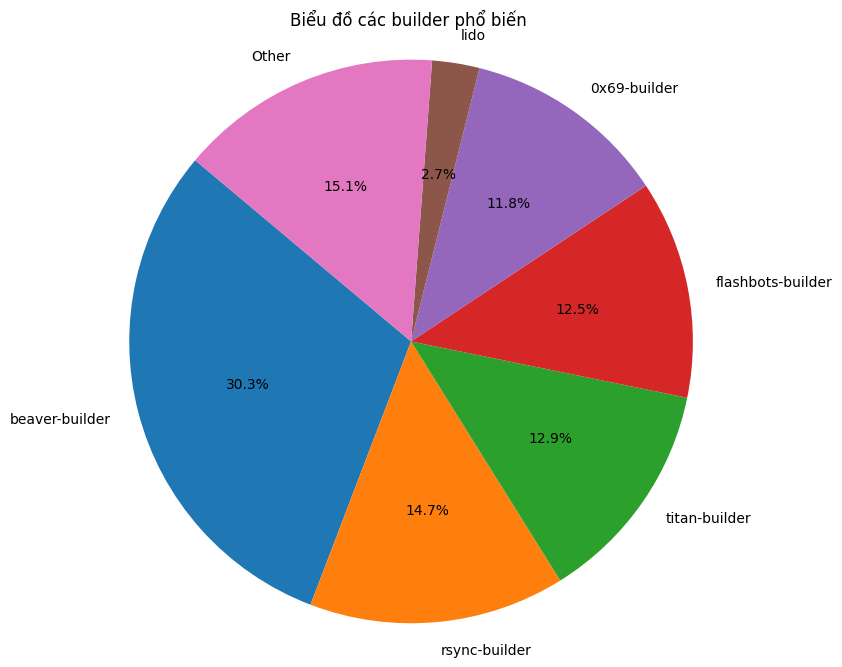

In [6]:
# Plot builder popular 
builder_popular = db.query(f"""
    WITH top_builders AS (
        SELECT 
            builder_address,
            COUNT(1) AS bundle_count
        FROM bundles
        GROUP BY builder_address
        ORDER BY bundle_count DESC
        LIMIT 6
    ),
    other_builders AS (
        SELECT 
            'Other' AS builder_address,
            COUNT(1) AS bundle_count
        FROM bundles
        WHERE builder_address NOT IN (SELECT builder_address FROM top_builders)
    )
    SELECT * FROM top_builders
    UNION ALL
    SELECT * FROM other_builders;
""")

df = pd.DataFrame(builder_popular, columns=['builder', 'bundle_count'])

df['percentage'] = (df['bundle_count'] / df['bundle_count'].sum()) * 100

alias_map = {
    '0x95222290dd7278aa3ddd389cc1e1d165cc4bafe5': 'beaver-builder',
    '0x1f9090aae28b8a3dceadf281b0f12828e676c326': 'rsync-builder',
    '0x4838b106fce9647bdf1e7877bf73ce8b0bad5f97': 'titan-builder',
    '0xdafea492d9c6733ae3d56b7ed1adb60692c98bc5': 'flashbots-builder',
    '0x690b9a9e9aa1c9db991c7721a92d351db4fac990': '0x69-builder',
    '0x388c818ca8b9251b393131c08a736a67ccb19297': 'lido',
    '0x4675c7e5baafbffbca748158becba61ef3b0a263': 'mev-builder-0x46',
    '0xbaf6dc2e647aeb6f510f9e318856a1bcd66c5e19': 'mev-builder-0xba',
    '0xfeebabe6b0418ec13b30aadf129f5dcdd4f70cea': 'eth-builder',
    '0xbd3afb0bb76683ecb4225f9dbc91f998713c3b01': 'buildAI.net'
}

df['builder'] = df['builder'].replace(alias_map)
plt.figure(figsize=(8, 8))
plt.pie(df['percentage'], labels=df['builder'], autopct='%1.1f%%', startangle=140)
plt.title('Biểu đồ các builder phổ biến ')
plt.axis('equal')
plt.show()

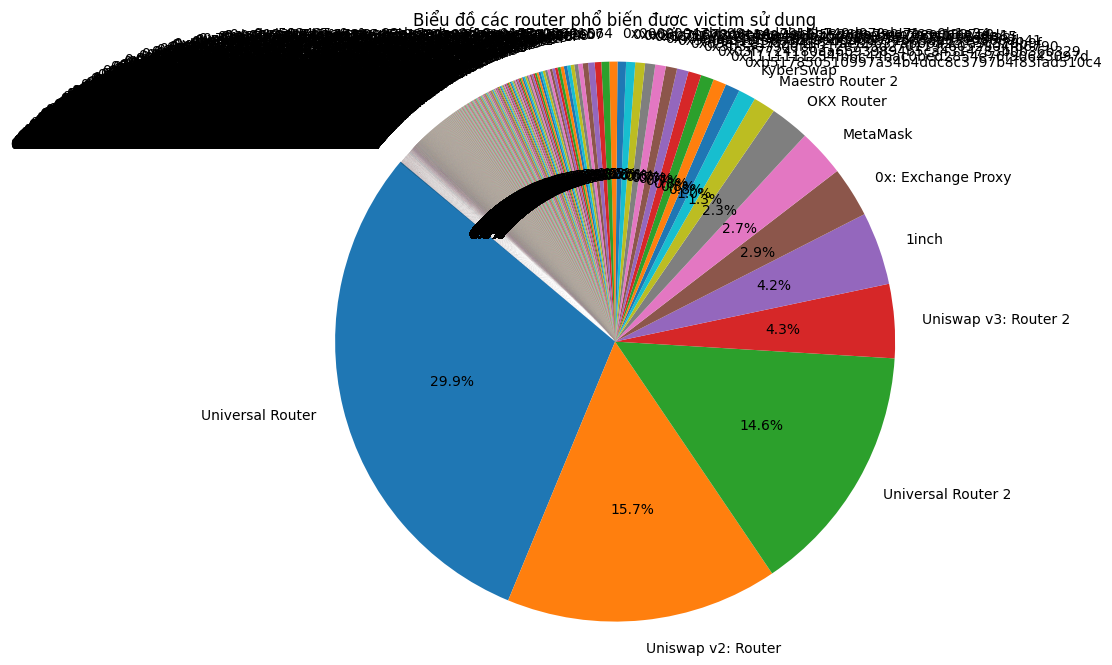

In [5]:

to_popular = db.query(f"""
    SELECT t."to", COUNT(1) AS count
    FROM txs t
    LEFT JOIN tx_filters tf ON t.tx_hash = tf.tx_hash
    WHERE tf.tx_hash IS NULL
    GROUP BY t."to"
    ORDER BY count DESC
""")

df = pd.DataFrame(to_popular, columns=['to', 'count'])

excluded_addresses = [
    '0x6b75d8af000000e20b7a7ddf000ba900b4009a80',
    '0x00000000009e50a7ddb7a7b0e2ee6604fd120e49',
    '0x77d5f03822f94b39ad6117f6a46761ec5879031b',
    '0x24902aa0cf0000a08c0ea0b003b0c0bf600000e0',
    '0x00000000a991c429ee2ec6df19d40fe0c80088b8',
    '0x5079fc00f00f30000e0c8c083801cfde000008b6',
    '0x507888e987257a8dde6f8afa46375cefe2cbf504',
    '0x000000d40b595b94918a28b27d1e2c66f43a51d3',
    '0x0eae044f00b0af300500f090ea00027097d03000',
    
]

alias_map = {
    '0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad': 'Universal Router',
    '0x7a250d5630b4cf539739df2c5dacb4c659f2488d': 'Uniswap v2: Router',
    '0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b': 'Universal Router 2',
    '0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45': 'Uniswap v3: Router 2',
    '0x1111111254eeb25477b68fb85ed929f73a960582': '1inch',
    '0xdef1c0ded9bec7f1a1670819833240f027b25eff': '0x: Exchange Proxy',
    '0x881d40237659c251811cec9c364ef91dc08d300c': 'MetaMask',
    '0xf3de3c0d654fda23dad170f0f320a92172509127': 'OKX Router',
    '0x80a64c6d7f12c47b7c66c5b4e20e72bc1fcd5d9e': 'Maestro Router 2',
    '0x6131b5fae19ea4f9d964eac0408e4408b66337b5': 'KyberSwap'
}

df_filtered = df[~df['to'].isin(excluded_addresses)].copy()
df_filtered['to'] = df_filtered['to'].replace(alias_map)
plt.figure(figsize=(10, 8))
plt.pie(df_filtered['count'], labels=df_filtered['to'], autopct='%1.1f%%', startangle=140)
plt.title('Biểu đồ các router phổ biến được victim sử dụng')
plt.axis('equal')
plt.show()

In [ ]:
func_sig = db.query(f"""
    SELECT SUBSTRING("input" FROM 1 FOR 10) AS method_sig, COUNT(1) AS count_sig
    FROM txs
    GROUP BY method_sig
    ORDER BY count_sig DESC
    LIMIT 14
""")

alias_map = {
    '0x3593564c': 'execute(): universal-router',
    '0x791ac947': 'swapExactTokensForETHSupportingFeeOnTransferTokens(): uniswap-v2',
    '0xb6f9de95': 'swapExactETHForTokensSupportingFeeOnTransferTokens(): uniswap-v2',
    '0x5ae401dc': 'multicall() - uniswap-v3-router-2',
    '0x7ff36ab5': 'swapExactETHForTokens(): uniswap-v2',
    '0x5f575529': 'swap() - metamask-router',
    '0x9871efa4': 'unxswapByOrderId() - okx-router',
    '0x18cbafe5': 'swapExactTokensForETH(): uniswap-v2',
}

excluded_sig = [
    '0x00000000',
    '0x12aa3caf',
    '0xbc4a02e4',
    '0x55f86501',
    '0xca8bd1f9',
    '0x01000203'
]

df = pd.DataFrame(func_sig, columns=['method_sig', 'count_sig'])
df_filtered = df[~df['method_sig'].isin(excluded_sig)].copy()
df_filtered['method_sig'] = df_filtered['method_sig'].replace(alias_map)
plt.figure(figsize=(10, 7))
plt.pie(df_filtered['count_sig'], labels=df_filtered['method_sig'], autopct='%1.1f%%', startangle=140)
plt.title('Biểu đồ tỷ lệ sử dụng API phổ biến swap')
plt.axis('equal') 
plt.show()

In [ ]:
protocol_popular = db.query(f"""
    SELECT name, COUNT(1) AS count
    FROM tx_filters, UNNEST(address_names) AS name
    GROUP BY name
    ORDER BY count DESC
    LIMIT 9
""")

excluded_protocol = [
    'UniswapV2'
]

df = pd.DataFrame(protocol_popular, columns=['protocol', 'count'])
df_filtered = df[~df['protocol'].isin(excluded_protocol)].copy()
plt.figure(figsize=(10, 8))
plt.pie(df_filtered['count'], labels=df_filtered['protocol'], autopct='%1.1f%%', startangle=140)
plt.title('Biểu đồ thị phần v3, các dex aggregator, và các protocol cho vay')
plt.axis('equal')
plt.show()

In [ ]:
pair_popular = db.query(f"""
    SELECT addr, COUNT(1) AS count
    FROM tx_filters, UNNEST(addresses) AS addr
    GROUP BY addr
    ORDER BY count DESC
    LIMIT 20
""")

excluded_pair = [
    '0xba12222222228d8ba445958a75a0704d566bf2c8',
    '0x1111111254eeb25477b68fb85ed929f73a960582',
    '0x6000da47483062a0d734ba3dc7576ce6a0b645c4',
    '0x111111125421ca6dc452d289314280a0f8842a65'
]

alias_map = {
    '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640': 'Uniswap V3: USDC - WETH',
    '0x11b815efb8f581194ae79006d24e0d814b7697f6': 'Uniswap V3: WETH - USDT',
    '0x4585fe77225b41b697c938b018e2ac67ac5a20c0': 'Uniswap V3: WBTC - WETH',
    '0x60594a405d53811d3bc4766596efd80fd545a270': 'Uniswap V3: DAI - WETH',
    '0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b': 'Uniswap V3: WETH - USDT',
    '0xe0554a476a092703abdb3ef35c80e0d76d32939f': 'Uniswap V3: WETH - USDC',
    '0x9e0905249ceefffb9605e034b534544684a58be6': 'Uniswap V3: HEX - WETH',
    '0x3416cf6c708da44db2624d63ea0aaef7113527c6': 'Uniswap V3: USDC - USDT',
    '0x109830a1aaad605bbf02a9dfa7b0b92ec2fb7daa': 'Uniswap V3: wstETH - WETH',
    '0xa43fe16908251ee70ef74718545e4fe6c5ccec9f': 'Uniswap V2: PEPE - WETH',
    '0xefb47fcfcad4f96c83d4ca676842fb03ef20a477': 'ShibaSwap: BONE - WETH',
    '0x9a772018fbd77fcd2d25657e5c547baff3fd7d16': 'Uniswap V3: WBTC - USDC',
    '0x2cc846fff0b08fb3bffad71f53a60b4b6e6d6482': 'Uniswap V2: HarryPotterObamaSonic10Inu - WETH',
    '0x735a26a57a0a0069dfabd41595a970faf5e1ee8b': 'Uniswap V3: agEUR - USDC',
    '0x55d5c232d921b9eaa6b37b5845e439acd04b4dba': 'Uniswap V2: HEX - WETH',
    '0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc': 'Uniswap V2: USDC - WETH',
}


df = pd.DataFrame(pair_popular, columns=['pair', 'count'])
df_filtered = df[~df['pair'].isin(excluded_pair)].copy()
df_filtered['pair'] = df_filtered['pair'].replace(alias_map)
plt.figure(figsize=(10, 8))
plt.pie(df_filtered['count'], labels=df_filtered['pair'], autopct='%1.1f%%', startangle=140)
plt.title('Biểu đồ các pair phổ biến MEV')
plt.axis('equal')
plt.show()